In [ ]:
import numpy as np
import pyshtools as pysh
#from read_grav import grgm1200b
import matplotlib as plt
import boule as bl
import pandas as pd
import xarray as xr
import harmonica as hm
import verde as vd
import pygmt
from pathlib import Path

In [3]:
height = 11e3
porosity = 0.12

In [ ]:
PROJECT_ROOT = Path.cwd().parent
data_filename=PROJECT_ROOT/"data/density_no_mare_n3000_f3050_719.sh"
result_filename=PROJECT_ROOT/"data/boueguer_tesseroid_1deg.csv"

In [ ]:
# 密度
densityfile = data_filename
density = pysh.SHCoeffs.from_file(densityfile, lmax=719)
density_grid=density.expand(grid='DH',lmax=719,extend=False)
density_xr=density_grid.to_xarray()
# 重力
pot=pysh.datasets.Moon.GRGM1200B()
pot.set_omega(bl.Moon2015.angular_velocity)
pot=pot.change_ref(gm=bl.Moon2015.geocentric_grav_const, r0=bl.Moon2015.radius)
pot_grid= pot.expand(lmax=539, a=bl.Moon2015.radius + height, f=0, normal_gravity=False, extend=False)
pot_xr=pot_grid.to_xarray()
# 地形
topo=pysh.datasets.Moon.LDEM_shape_pa()
topo_grid=topo.expand(grid='DH',lmax=1200,extend=False)
topo_xr=topo_grid.to_xarray()

In [5]:
region=(0, 359.99999, -90, 90)
grid_longitude, grid_latitude = vd.grid_coordinates(region=region, shape=(181,361))
lon_o=np.sort(np.unique(grid_longitude))
lat_o=np.sort(np.unique(grid_latitude))
lon = 0.5 * (lon_o[:-1] + lon_o[1:])
lat = 0.5 * (lat_o[:-1] + lat_o[1:])
pot_xr_sub=pot_xr.interp(lat=lat,lon=lon)
density_xr_sub=density_xr.interp(lat=lat,lon=lon)
topo_xr_sub=topo_xr.interp(lat=lat,lon=lon)
LON, LAT = np.meshgrid(lon, lat) 

In [6]:
Moon2015_el=bl.Moon2015
gamma=Moon2015_el.normal_gravity(latitude=LAT,height=height)

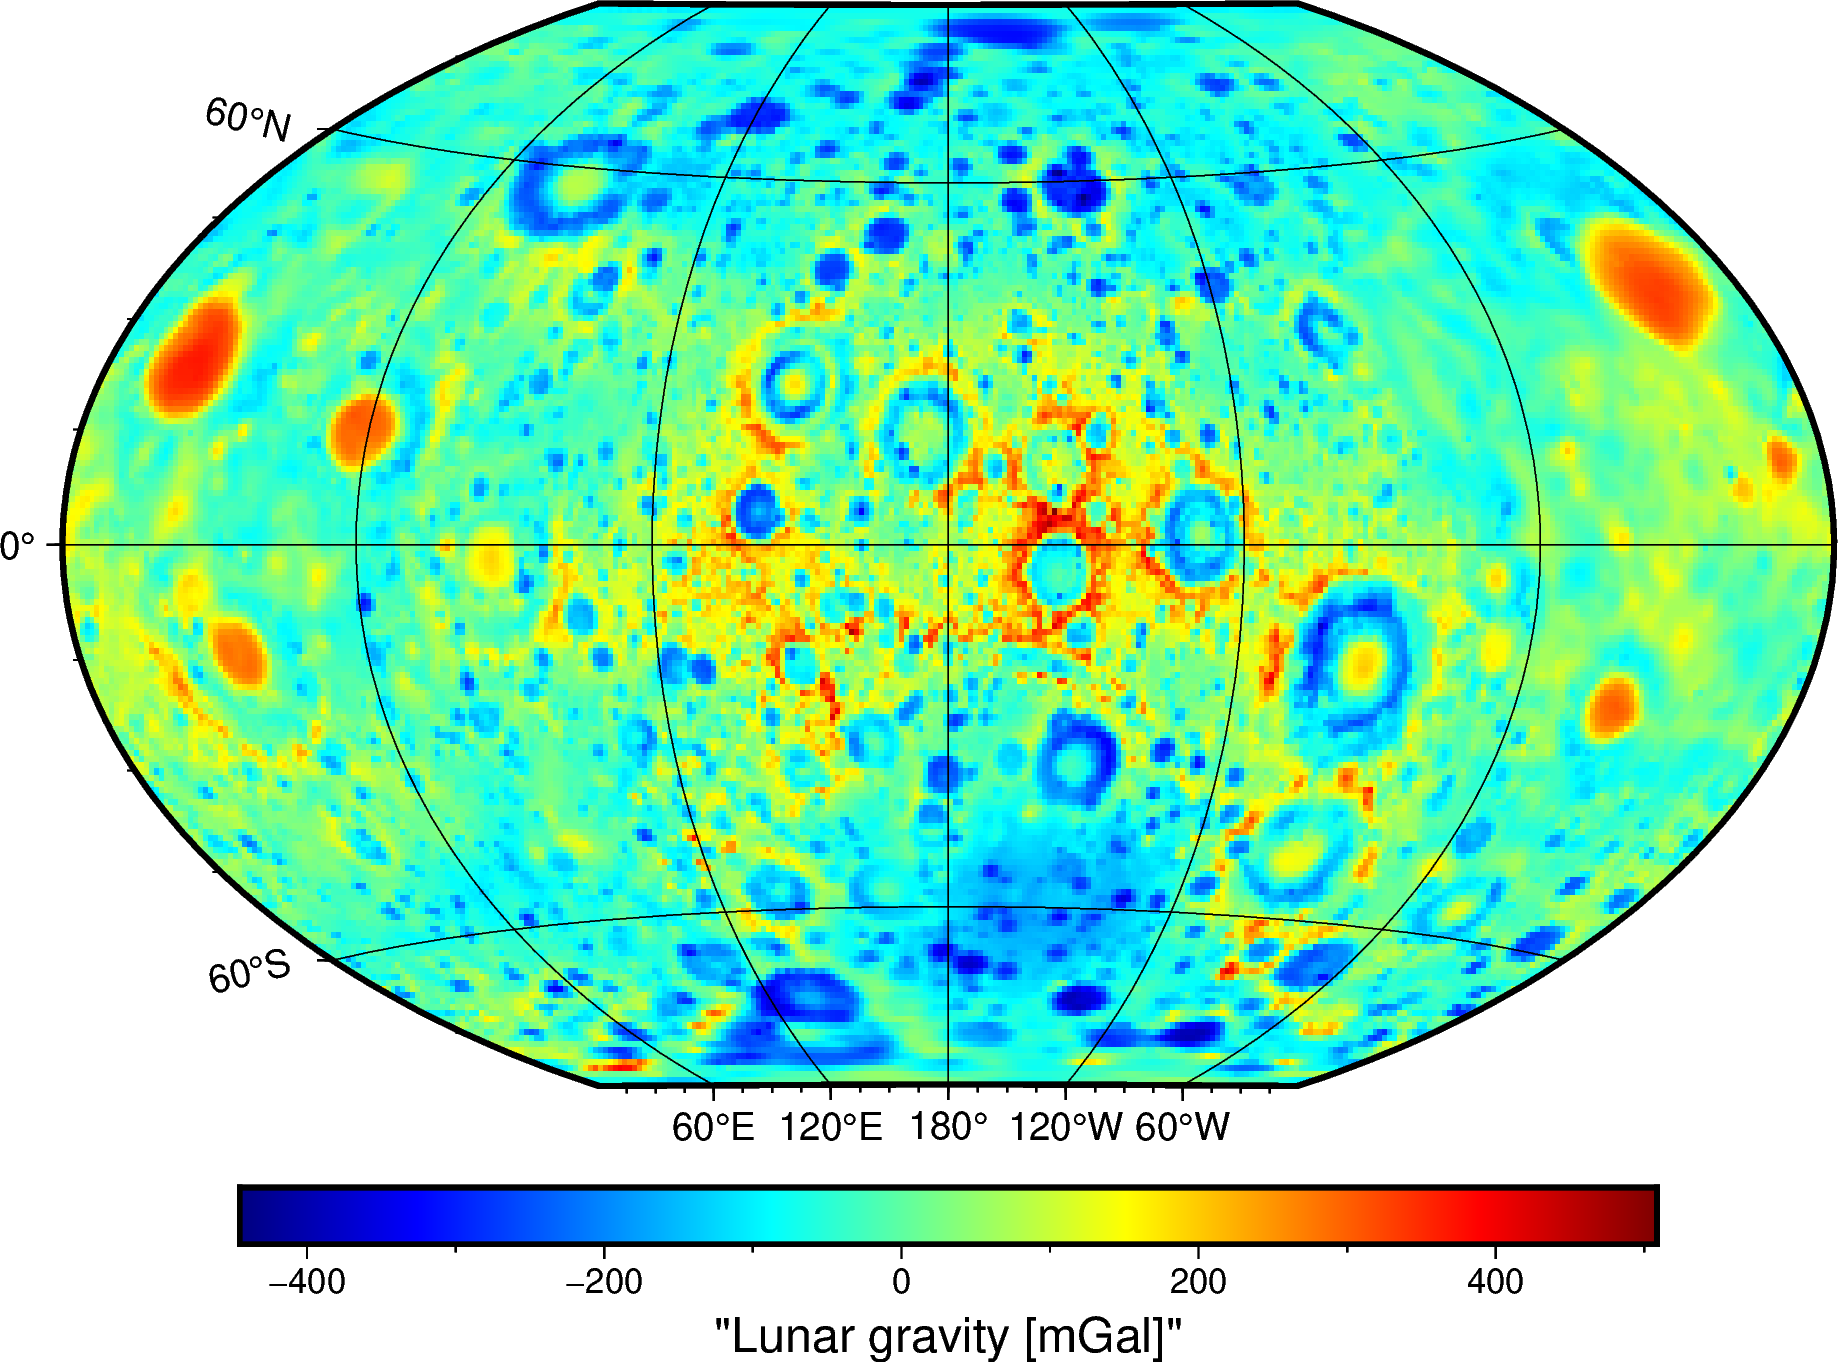

In [7]:
data=-pot_xr_sub.radial.data*1e5-gamma
freeair_xr=xr.DataArray(data,dims=('lat','lon'),coords={'lat': lat,'lon': lon})
with pygmt.config(PROJ_ELLIPSOID=f"{bl.Moon2015.radius}f=0"):
    fig = pygmt.Figure()
    fig.grdimage(
        freeair_xr,
        projection="R15c",
        cmap="jet",
        frame="afg",
    )
    fig.colorbar(frame='af+l"Lunar gravity [mGal]"')
    fig.savefig("preview.jpg")
    fig.show()

In [8]:
surface=topo_xr_sub.data

density_array=density_xr_sub.data.copy()
density_array[(topo_xr_sub.data-bl.Moon2015.mean_radius)<=0]*=-1

reference=bl.Moon2015.mean_radius*np.ones_like(LAT)
coordinates=(LON,LAT,reference+height)
topo_layer=hm.tesseroid_layer((lon,lat),surface=surface,reference=reference,properties={"density":density_array})
topo_g=topo_layer.tesseroid_layer.gravity(coordinates, field="g_z",progressbar=True)

  0%|          | 0/64800 [00:00<?, ?it/s]

In [9]:
topo_layer

<xarray.Dataset> Size: 2MB
Dimensions:    (latitude: 180, longitude: 360)
Coordinates:
  * longitude  (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    top        (latitude, longitude) float64 518kB 1.737e+06 ... 1.737e+06
    bottom     (latitude, longitude) float64 518kB 1.737e+06 ... 1.736e+06
Data variables:
    density    (latitude, longitude) float64 518kB -2.908e+03 ... -2.914e+03
Attributes:
    longitude_units:   degrees
    latitude_units:    degrees
    radius_units:      meters
    properties_units:  SI

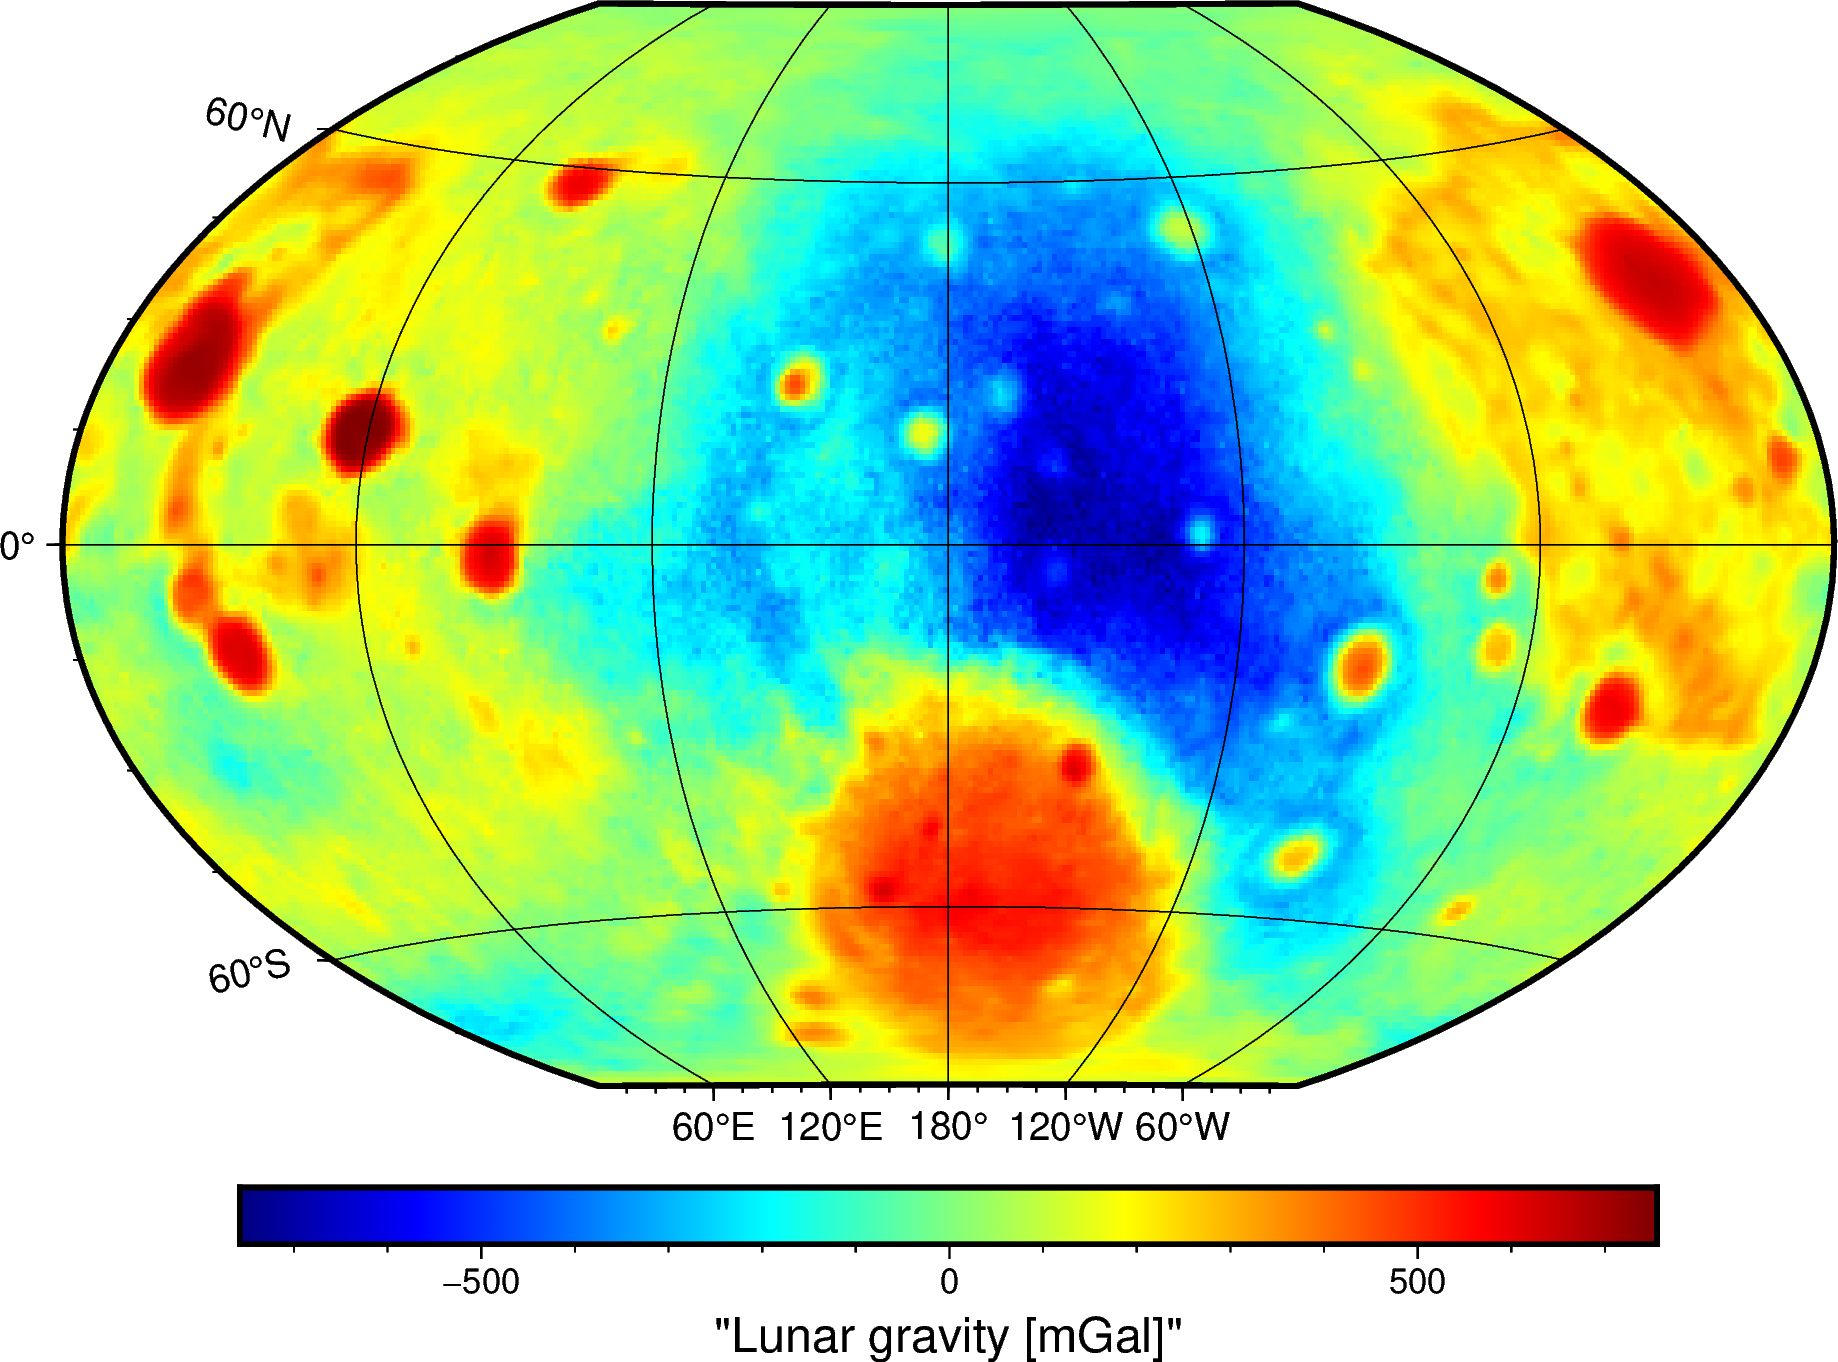

In [10]:
boueguer_xr=freeair_xr.copy()
boueguer_xr.data-=topo_g
with pygmt.config(PROJ_ELLIPSOID=f"{bl.Moon2015.radius}f=0"):
    fig = pygmt.Figure()
    fig.grdimage(
        boueguer_xr,
        projection="R15c",
        cmap="jet",
        frame="afg",
    )
    fig.colorbar(frame='af+l"Lunar gravity [mGal]"')
    fig.savefig("preview.jpg")
    fig.show()

In [29]:
df=(
    boueguer_xr
    .stack(points=('lat','lon'))
    .reset_index('points')
    .to_dataframe(name='deltaN')
    .reset_index(drop=True)
)
topo_xr_sub.data=topo_xr_sub.data-bl.Moon2015.mean_radius
df_topo=(
    topo_xr_sub
    .stack(points=('lat','lon'))
    .reset_index('points')
    .to_dataframe(name='topo')
    .reset_index(drop=True)
)
df=df.merge(df_topo,on=['lon', 'lat'],how='left')
df

,lat,lon,deltaN,topo
0,-89.5,0.50000,99.976631,-1.737720e+06
1,-89.5,1.50000,99.957292,-1.737694e+06
2,-89.5,2.50000,99.933014,-1.737668e+06
3,-89.5,3.50000,99.903989,-1.737641e+06
4,-89.5,4.50000,99.870414,-1.737614e+06
...,...,...,...,...
64795,89.5,355.49999,21.683299,-1.737921e+06
64796,89.5,356.49999,21.802903,-1.737939e+06
64797,89.5,357.49999,21.923401,-1.737956e+06
64798,89.5,358.49999,22.044728,-1.737973e+06


In [28]:
def gmtplot_g(topo_xr_sub):
    with pygmt.config(PROJ_ELLIPSOID=f"{bl.Moon2015.radius}f=0"):
        fig = pygmt.Figure()
        fig.grdimage(
            topo_xr_sub,
            projection="R15c",
            cmap="jet",
            frame="afg",
        )
        fig.colorbar()
        fig.savefig("preview.jpg")
        fig.show()

In [ ]:
df.to_csv(
    result_filename,
    index=False,        # 不输出行号
    float_format='%.6f' # 控制浮点精度，重力数据一般够用
)